In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
# """installs"""

# !pip install nc-time-axis
# !pip install netCDF4 h5netcdf
# !pip install xarray
# !pip install cdsapi
# !pip install networkx geopandas osmnx igraph matplotlib
# !pip install pysal scikit-learn libpysal tobler geopandas numpy pandas networkx
# !pip install access
# !pip install transliterate


In [3]:
import sys
from pathlib import Path

# Add parent directory to Python path to enable imports from scripts/
module_path = str(Path.cwd().parent)
if module_path not in sys.path:
    sys.path.append(module_path)


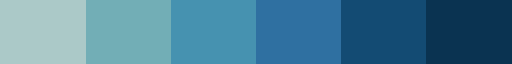

In [4]:
import scicolor

scicolor.get_cmap("Hokusai2")


In [5]:
# """
# проверить какой провижен новый или нет я юзаю
# """


In [6]:
import matplotlib.pyplot as plt

from constants import (
    START_YEAR,
    MONTHS_IN_YEAR,
    CONST_BASE_DEMAND,
    transport_modes,
    transport_modes_color,
    service_radius_minutes,
    transport_mode_name_mapper,
    service_list,
    threshold,
)
import scripts.provision as provision
from tqdm import tqdm

tqdm.pandas()


In [7]:
from ..scripts.calculator.calculator_this_pipeline import make_block_scheme


ImportError: attempted relative import with no known parent package

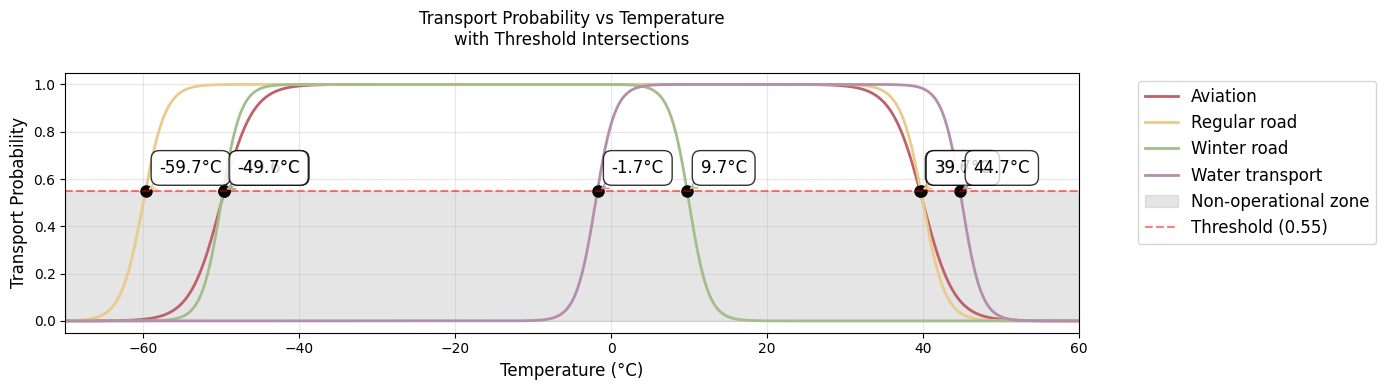

In [ ]:
from plotter_transport_mode_prob import plot_transport_probability_legacy
from ..scripts.calculator.calculator_transport_prob import get_transport_probability

threshold_temperatures = plot_transport_probability_legacy(
    transport_modes,
    transport_modes_color,
    get_transport_probability,
    threshold,
    temps=None,
    font_size=12,
)


In [ ]:
from preprocesser import get_data
from gcreator import make_g, add_temp_to_g
from plotter_network_basic import plot_transport_graph
from huston import call_nasa
from ..scripts.calculator.calculator_stat import create_agglomeration_network
from ..scripts.calculator.calculator_monthly_mode import create_df_modes_monthly_fixed
from plotter_heatmap import create_transport_mode_heatmaps
from plotter_heatmap_prov_node import plot_provision_evolution_by_node

# Store results for each settlement and service
all_results = {}
# yakut_chuk
# yanao_kras
# mezen
# nao

data_path = "../data/"

for SETTL_NAME in ["yakut_chuk"]:
    print("=" * 10, SETTL_NAME, "=" * 10)

    # Initialize settlement results
    all_results[SETTL_NAME] = {}
    # service_list
    for SERVICE_NAME in service_list:
        print(" " * 10, SERVICE_NAME, " " * 10)

        CLIMATE_DATA_FILE_NAME = f"df_climate_{SETTL_NAME}.csv"

        settl, df_service, transport_df, infr_df = get_data(
            data_path,
            SETTL_NAME,
            transport_mode_name_mapper,
            transport_modes,
            SERVICE_NAME,
        )
        blocks_gdf = make_block_scheme(settl, df_service, service_name=SERVICE_NAME)
        G_undirected = make_g(transport_df, transport_modes, blocks_gdf, settl)

        df_monthly_list = call_nasa(blocks_gdf, CLIMATE_DATA_FILE_NAME)
        G_undirected = add_temp_to_g(G_undirected, df_monthly_list)

        range_months = range(12)  # Starting 1982

        net = create_agglomeration_network(
            graph=G_undirected,
            threshold=threshold,
            probability_function=get_transport_probability,
            provision_calculator=provision.calculate_graph_provision,
        )

        net.run_all_steps(
            range_months,
            service_radius_minutes=service_radius_minutes[SETTL_NAME],
            base_demand=CONST_BASE_DEMAND,
            service_name=SERVICE_NAME,
            return_assignment=True,
        )

        # Store results for this service
        all_results[SETTL_NAME][SERVICE_NAME] = {
            "net": net,
            "stats": net.stats,
            "graphs": net.stats.graphs,
            "records": net.stats.records,
            "results": net.stats.results,
            "G_undirected": G_undirected,
        }

        # Предполагаем что индекс df_stats — это месяцы в виде `i` (0...len-1)
        df_stats = net.stats.records
        try:
            df_stats["Month"] = df_stats.index % MONTHS_IN_YEAR + 1
            df_stats["Year"] = START_YEAR + df_stats.index // MONTHS_IN_YEAR
        except Exception:
            pass

        df_modes_monthly = create_df_modes_monthly_fixed(
            G_undirected,
            transport_modes,
            threshold_temperatures,
            START_YEAR,
            MONTHS_IN_YEAR=12,
        )

        # Store df_modes_monthly as well
        all_results[SETTL_NAME][SERVICE_NAME]["df_modes_monthly"] = df_modes_monthly


========== yakut_chuk ==========
           post           


Running network analysis: 100%|██████████| 12/12 [00:00<00:00, 14.82it/s]


           culture           


Running network analysis: 100%|██████████| 12/12 [00:00<00:00, 15.92it/s]


           health           


Running network analysis: 100%|██████████| 12/12 [00:00<00:00, 15.50it/s]


           port           


Running network analysis: 100%|██████████| 12/12 [00:00<00:00, 16.89it/s]


           airport           


/Users/test/Documents/code/iccs25/new_notebooks/plotter_multilayer_service_network.py:172: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k--" (-> linestyle='--'). The keyword argument will take precedence.
  ax.plot(


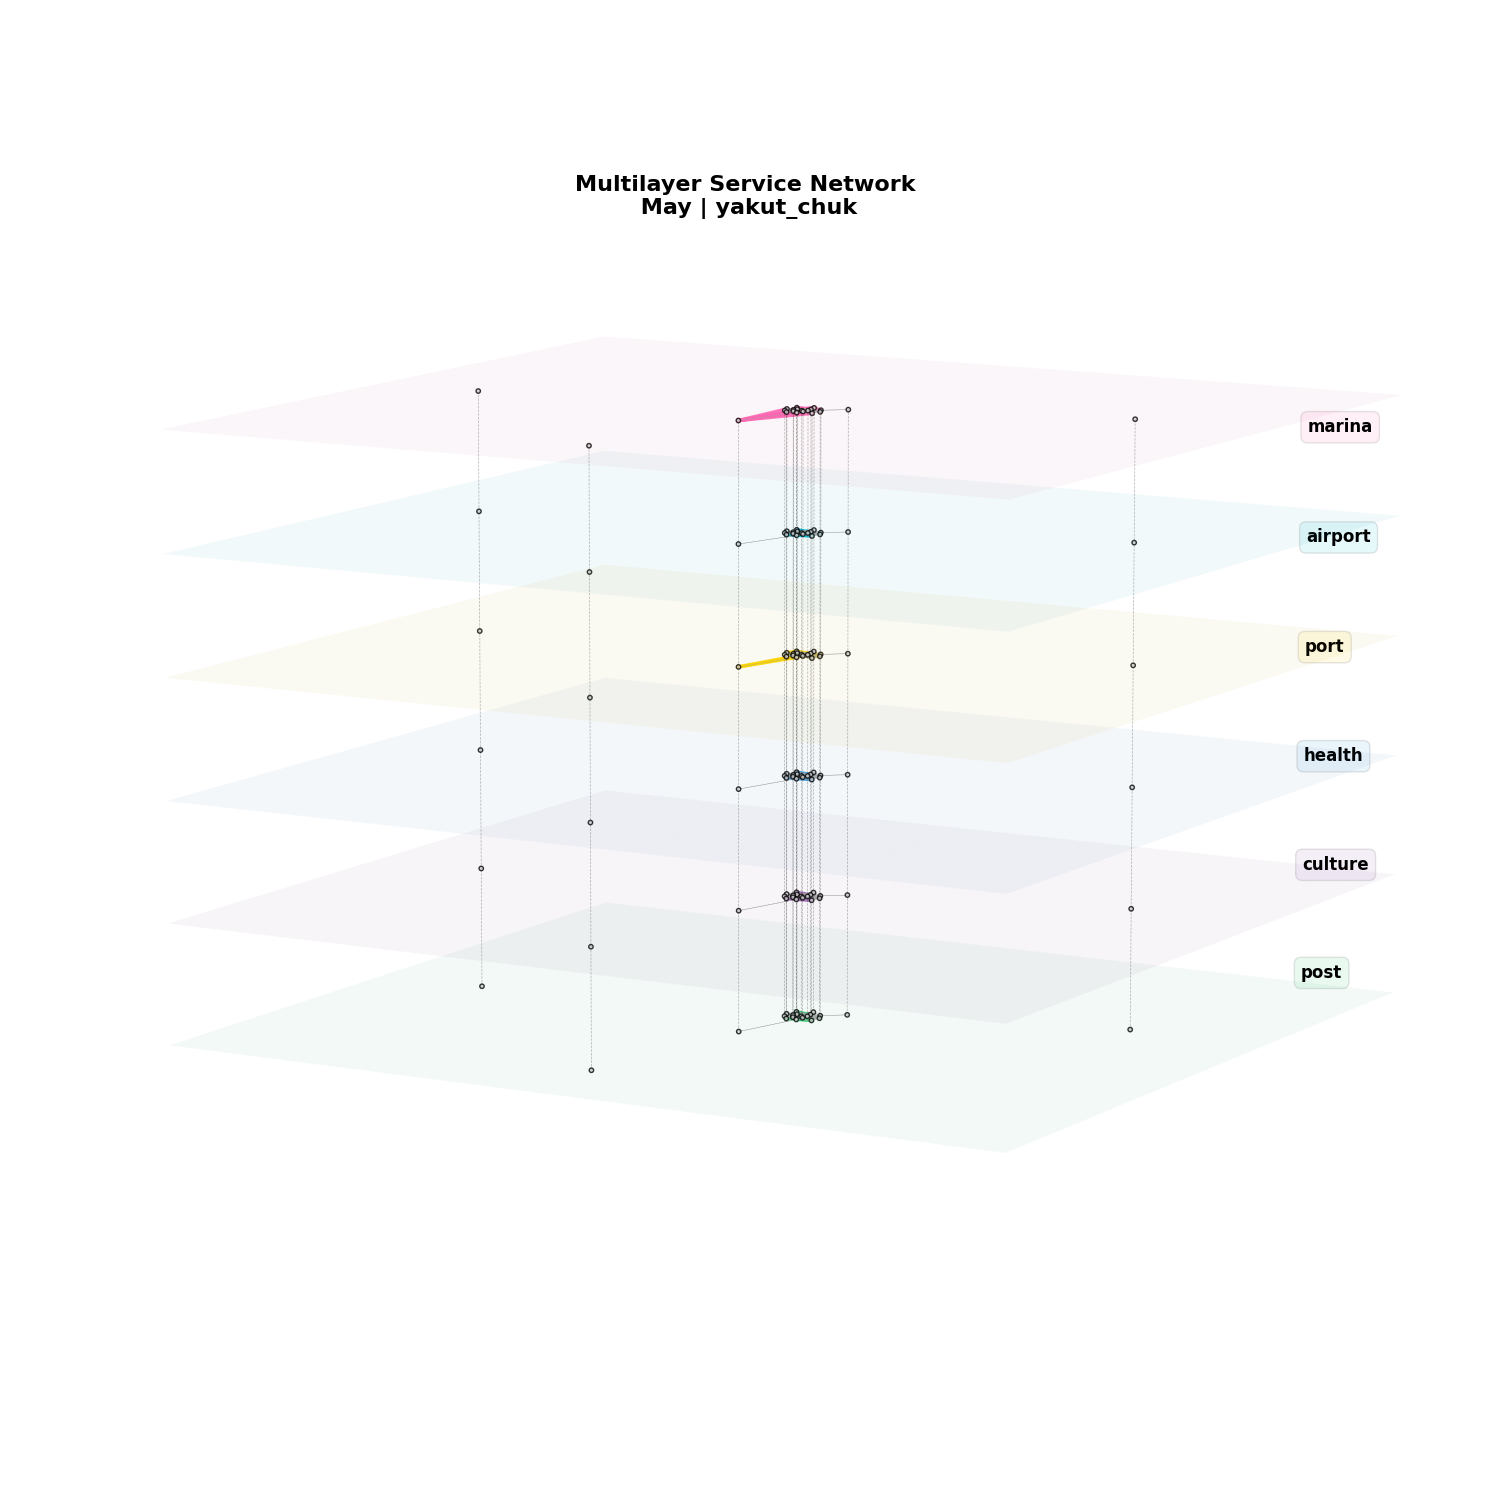

In [ ]:
from plotter_multilayer_service_network import plot_multilayer_network
from constants import month_order

month = 4

# Example usage:
fig = plot_multilayer_network(
    all_results, SETTL_NAME, service_list, month=month, figsize=(15, 30)
)
plt.tight_layout()
# plt.show()

import time

time.sleep(2)  # Pause to ensure the plot is rendered before saving
plt.savefig(
    f"../plots/multilayer_network_{SETTL_NAME}_{month_order[month]}.png",
    bbox_inches="tight",
    dpi=300,
)


In [ ]:
from plotter_flow_sankey import create_clean_sankey

# Usage:
# Usage example:
for service in service_list:
    # try:
    month_start = 4
    end_month = 10
    graphs = all_results[SETTL_NAME][service]["stats"].graphs[month_start:end_month]
    fig = create_clean_sankey(graphs, service_name=service, month_start=month_start)
    # except Exception as ex:
    # print(ex)

fig.show()


Creating Sankey for 6 time periods...
Excluding 16 self-sufficient settlements: ['Kolymskoe', 'Ebjah', 'Argahtah', 'Ostrovnoe', 'Magadan', 'Jakutsk', 'Keperveem', 'Anjujsk', 'Andrjushkino', 'Omolon', 'Cherskij', 'Svataj', 'Ojusardah', 'Ilirnej', 'Pohodsk', 'Sylgy-Ytar']
Found 5 consumers
T1: 3 assignments, 2 no provider
T2: 5 assignments, 0 no provider
T3: 5 assignments, 0 no provider
T4: 4 assignments, 1 no provider
T5: 5 assignments, 0 no provider
T6: 3 assignments, 2 no provider
Created 29 nodes
Created 30 flows


Creating Sankey for 6 time periods...
Excluding 16 self-sufficient settlements: ['Kolymskoe', 'Ebjah', 'Argahtah', 'Ostrovnoe', 'Magadan', 'Jakutsk', 'Keperveem', 'Anjujsk', 'Andrjushkino', 'Omolon', 'Cherskij', 'Svataj', 'Ojusardah', 'Ilirnej', 'Pohodsk', 'Sylgy-Ytar']
Found 5 consumers
T1: 3 assignments, 2 no provider
T2: 5 assignments, 0 no provider
T3: 5 assignments, 0 no provider
T4: 4 assignments, 1 no provider
T5: 5 assignments, 0 no provider
T6: 3 assignments, 2 no provider
Created 29 nodes
Created 30 flows


Creating Sankey for 6 time periods...
Excluding 16 self-sufficient settlements: ['Kolymskoe', 'Ebjah', 'Argahtah', 'Ostrovnoe', 'Magadan', 'Jakutsk', 'Keperveem', 'Anjujsk', 'Andrjushkino', 'Omolon', 'Cherskij', 'Svataj', 'Ojusardah', 'Ilirnej', 'Pohodsk', 'Sylgy-Ytar']
Found 5 consumers
T1: 3 assignments, 2 no provider
T2: 5 assignments, 0 no provider
T3: 5 assignments, 0 no provider
T4: 4 assignments, 1 no provider
T5: 5 assignments, 0 no provider
T6: 3 assignments, 2 no provider
Created 29 nodes
Created 30 flows


Creating Sankey for 6 time periods...
Excluding 9 self-sufficient settlements: ['Ermolovo', 'Nizhnekolymsk', 'Kolymskoe', 'Magadan', 'Jakutsk', 'Anjujsk', 'Dve Viski', 'Cherskij', 'Pohodsk']
Found 12 consumers
T1: 7 assignments, 5 no provider
T2: 7 assignments, 5 no provider
T3: 6 assignments, 6 no provider
T4: 4 assignments, 8 no provider
T5: 12 assignments, 0 no provider
T6: 7 assignments, 5 no provider
Created 34 nodes
Created 72 flows


Creating Sankey for 6 time periods...
Excluding 16 self-sufficient settlements: ['Kolymskoe', 'Ebjah', 'Argahtah', 'Ostrovnoe', 'Magadan', 'Jakutsk', 'Keperveem', 'Anjujsk', 'Andrjushkino', 'Omolon', 'Cherskij', 'Svataj', 'Ojusardah', 'Ilirnej', 'Pohodsk', 'Sylgy-Ytar']
Found 5 consumers
T1: 3 assignments, 2 no provider
T2: 5 assignments, 0 no provider
T3: 5 assignments, 0 no provider
T4: 4 assignments, 1 no provider
T5: 5 assignments, 0 no provider
T6: 3 assignments, 2 no provider
Created 29 nodes
Created 30 flows


Creating Sankey for 6 time periods...
Excluding 4 self-sufficient settlements: ['Jakutsk', 'Cherskij', 'Anjujsk', 'Magadan']
Found 17 consumers
T1: 14 assignments, 3 no provider
T2: 6 assignments, 11 no provider
T3: 6 assignments, 11 no provider
T4: 5 assignments, 12 no provider
T5: 17 assignments, 0 no provider
T6: 14 assignments, 3 no provider
Created 36 nodes
Created 102 flows


In [ ]:
from plotter_circular_network_sankey_style import plot_circular_network_sankey_style
from constants import month_order

for service in service_list:
    print(service)
    graphs = all_results[SETTL_NAME][service]["stats"].graphs[month_start:end_month]
    for i, g in enumerate(graphs):
        fig = plot_circular_network_sankey_style(
            g,
            service_name=service,
            month_name=month_order[month_start + i],
        )
        fig.show()
    print("=" * 10)


post


culture


health


port


airport


marina


In [ ]:
from plotter_multi_temporal_nx_plots import (
    run_complete_temporal_analysis,
)


🔄 Running analysis: yakut_chuk
   Services: 6 | Months: May-Aug

📅 Temporal evolution...


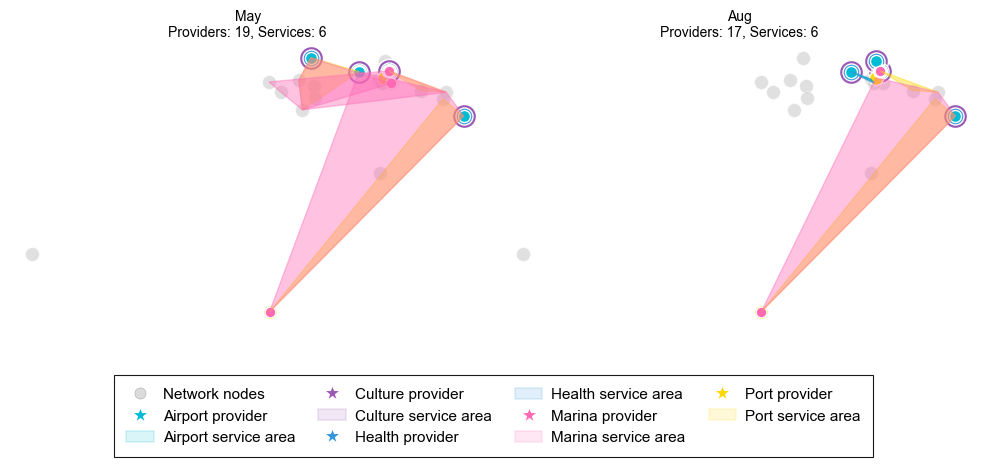


📊 Temporal metrics...


/Users/test/Documents/code/iccs25/new_notebooks/plotter_multi_temporal_nx_plots.py:227: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



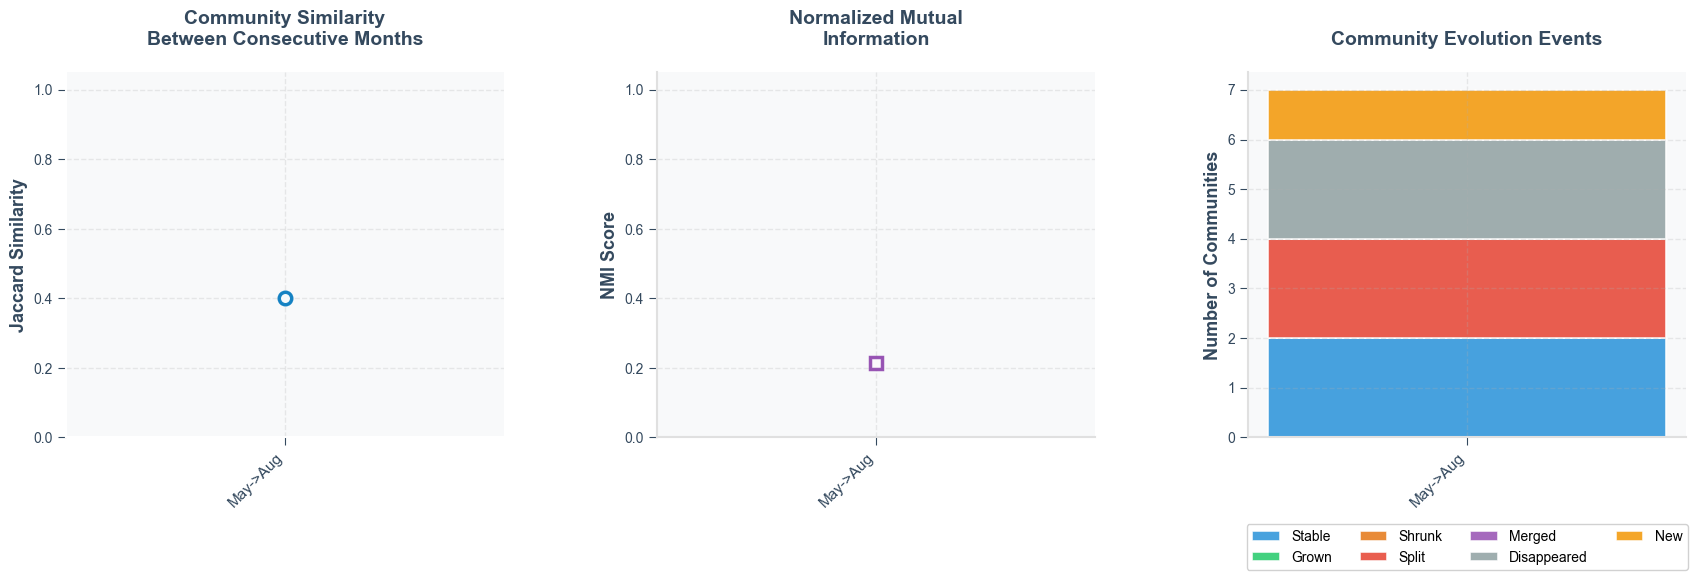

TEMPORAL MULTILAYER NETWORK ANALYSIS REPORT

📊 TEMPORAL STABILITY METRICS:
   Average Jaccard Similarity: 0.400
   Interpretation: Low temporal stability
   Average NMI Score: 0.213
   Average Persistence: 0.690

🔄 SELF-SUFFICIENCY EVOLUTION:
   Autarky trend: increasing
   Initial: 0.343, Final: 0.350

🌐 COMMUNITY DYNAMICS:
   Stable communities: 2
   Growing communities: 0
   Shrinking communities: 0
   Split events: 2
   Merge events: 0
   New communities: 1
   Disappeared: 2

🔍 KEY FINDINGS:
   ⚠ High temporal volatility in service provision
   ✓ Improving self-sufficiency over time



In [ ]:
MONTH_RANGE = range(4, 8, 3)  # May to October (indices 4-9)
results = run_complete_temporal_analysis(all_results, SETTL_NAME, MONTH_RANGE)


🔄 Running analysis: yakut_chuk
   Services: 6 | Months: Jan-Dec

📅 Temporal evolution...


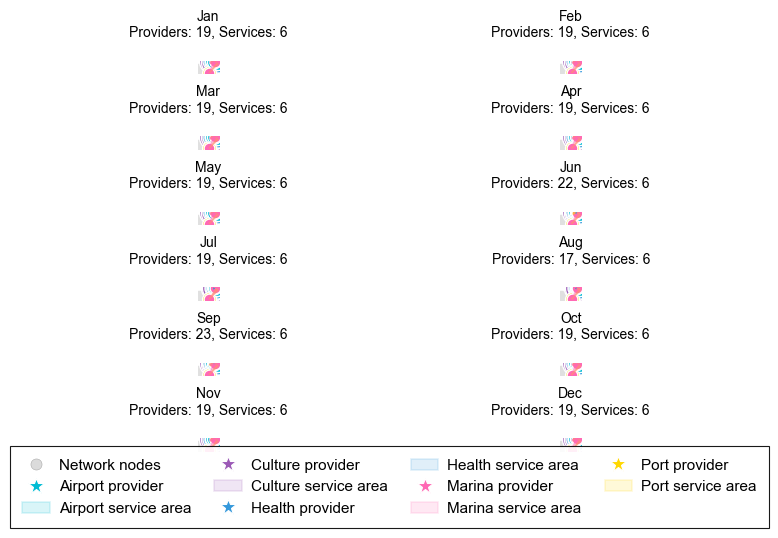


📊 Temporal metrics...


/Users/test/Documents/code/iccs25/new_notebooks/plotter_multi_temporal_nx_plots.py:227: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



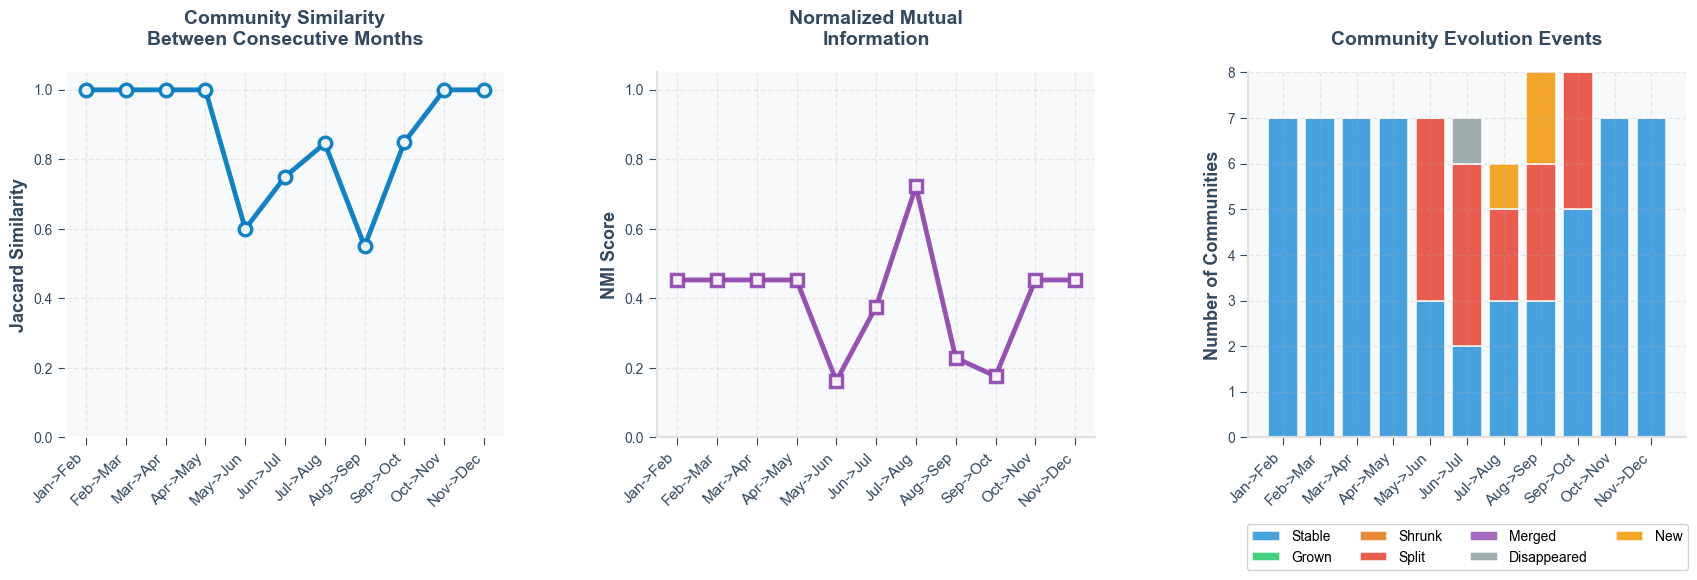

TEMPORAL MULTILAYER NETWORK ANALYSIS REPORT

📊 TEMPORAL STABILITY METRICS:
   Average Jaccard Similarity: 0.872
   Interpretation: High temporal stability
   Average NMI Score: 0.399
   Average Persistence: 0.933

🔄 SELF-SUFFICIENCY EVOLUTION:
   Autarky trend: decreasing
   Initial: 0.343, Final: 0.343

🌐 COMMUNITY DYNAMICS:
   Stable communities: 58
   Growing communities: 0
   Shrinking communities: 0
   Split events: 16
   Merge events: 0
   New communities: 3
   Disappeared: 1

🔍 KEY FINDINGS:
   ✓ Strong temporal persistence of service communities
   ⚠ Declining self-sufficiency requires attention



In [ ]:
MONTH_RANGE = range(12)  # May to October (indices 4-9)
results = run_complete_temporal_analysis(all_results, SETTL_NAME, MONTH_RANGE)


### 1.  prediction of network node attributes (provision type etc.) given structural network node properties (betweenness measures)

In [ ]:
"""
Нет
"""


'\nНет\n'

### 2.  we can represent the network of connectivity between cities  as multilayed network (structuring it by node attributes or by link types), this representation is an alternative  representation of seasonal  data as network structures

In [ ]:
"""
снова по типам ребер? Ну хз скорее нет
"""


'\nснова по типам ребер? Ну хз скорее нет\n'

### 3. Main (hub "опорные") cities selection based on the connectivity types. Depending on the connectivity type we can get separate main hub cities.

In [ ]:
"""
- выделение хабов по разным типам транспорта
-- маршруты через эти хабы
"""


'\n- выделение хабов по разным типам транспорта\n-- маршруты через эти хабы\n'

### 4. Characterisation of critical moments (given structural and node attribute properties). How to distinguish them using network analysis (solely) ?

In [ ]:
"""
- Перечислить что есть эти критичные моменты (без нетворк саенс)
- Перечислить что есть эти критичные моменты (с нетворк саенс)
"""


'\n- Перечислить что есть эти критичные моменты (без нетворк саенс)\n- Перечислить что есть эти критичные моменты (с нетворк саенс)\n'